In [1]:
## Notebook env: cell2loc_env (cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

Global seed set to 0


## Load in reference data, normalized and cell type + sample corrected

In [3]:
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/cell2location/predicted_celltype_annot'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map/N2_alpha200'

In [4]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File                                                                                                      
         /home/ssobti/projects/farnaz_spatial/output_data/cell2location/predicted_celltype_annot/reference_signatur
         es/model.pt already downloaded                                                                            


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/101:   1%|          | 1/101 [00:03<05:37,  3.38s/it, v_num=1, elbo_train=1.17e+9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/101:   1%|          | 1/101 [00:03<05:38,  3.38s/it, v_num=1, elbo_train=1.17e+9]


In [5]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]



ASPC       LEC       SMC  adipocyte    b_cell
0610005C13Rik  0.000442  0.038286  0.004073   0.039265  0.001901
0610009E02Rik  0.025620  0.022117  0.022656   0.074787  0.003822
0610009O20Rik  0.045808  0.065896  0.087901   0.107800  0.022756
0610010F05Rik  0.177539  0.113823  0.157846   0.938734  0.028184
0610012G03Rik  0.001308  0.003693  0.010611   0.101736  0.008172

In [6]:
inf_aver

ASPC       LEC       SMC  adipocyte    b_cell  \
0610005C13Rik  0.000442  0.038286  0.004073   0.039265  0.001901   
0610009E02Rik  0.025620  0.022117  0.022656   0.074787  0.003822   
0610009O20Rik  0.045808  0.065896  0.087901   0.107800  0.022756   
0610010F05Rik  0.177539  0.113823  0.157846   0.938734  0.028184   
0610012G03Rik  0.001308  0.003693  0.010611   0.101736  0.008172   
...                 ...       ...       ...        ...       ...   
Wfdc10         0.000319  0.457608  0.592181   0.001512  0.655382   
Gm29099        0.001077  0.705611  0.849010   0.003434  0.747800   
Prm2           0.000291  0.554121  0.511997   0.000708  0.579564   
AC125444.1     0.000843  0.655036  0.630586   0.003104  0.540198   
Gm29508        0.000427  0.837705  0.847853   0.001104  0.501294   

               dendritic_cell  endometrium  endothelial  macrophage  \
0610005C13Rik        0.000796     0.007008     0.000382    0.002312   
0610009E02Rik        0.001867     0.029302     0.011388    0.008193   
0610009O20Rik        0.017578     0.064336     0.034764    0.029641   
0610010F05Rik        0.097834     0.160783     0.174543    0.185976   
0610012G03Rik        0.005813     0.009427     0.009925    0.055362   
...                       ...          ...          ...         ...   
Wfdc10               0.460111     0.587929     0.346717    0.000276   
Gm29099              0.699515     0.687853     0.426383    0.000673   
Prm2                 0.501278     0.489303     0.397910    0.000155   
AC125444.1           0.419722     0.614823     0.541043    0.000866   
Gm29508              0.602315     0.399688     0.352340    0.000235   

               mast_cell  mesothelium  monocyte  neutrophil   nk_cell  \
0610005C13Rik   0.009996     0.006092  0.001098    0.032224  0.007120   
0610009E02Rik   0.040445     0.032233  0.000879    0.056346  0.007175   
0610009O20Rik   0.154400     0.058907  0.014265    0.054650  0.007168   
0610010F05Rik   0.235717     0.192010  0.031102    0.129941  0.013254   
0610012G03Rik   0.022604     0.014720  0.001056    0.046874  0.008721   
...                  ...          ...       ...         ...       ...   
Wfdc10          0.348413     0.448013  0.549662    0.931617  0.980948   
Gm29099         0.746031     0.599940  0.806699    0.884358  0.958797   
Prm2            0.480627     0.467691  0.706812    0.962946  1.065636   
AC125444.1      0.342583     0.571036  0.593446    0.962640  0.868308   
Gm29508         0.498133     0.380276  0.668317    0.917896  0.968962   

               pericyte    t_cell  
0610005C13Rik  0.010865  0.000589  
0610009E02Rik  0.081414  0.002379  
0610009O20Rik  0.099476  0.017499  
0610010F05Rik  0.131623  0.037911  
0610012G03Rik  0.062549  0.001519  
...                 ...       ...  
Wfdc10         0.890844  0.649548  
Gm29099        1.045046  0.884817  
Prm2           1.021107  0.592548  
AC125444.1     0.997206  0.425817  
Gm29508        0.925343  0.629102  

[14571 rows x 16 columns]

In [7]:
adata_ref.uns['mod']['factor_names']

array(['ASPC', 'LEC', 'SMC', 'adipocyte', 'b_cell', 'dendritic_cell',
       'endometrium', 'endothelial', 'macrophage', 'mast_cell',
       'mesothelium', 'monocyte', 'neutrophil', 'nk_cell', 'pericyte',
       't_cell'], dtype=object)

In [8]:
adata_ref.varm['means_per_cluster_mu_fg']

means_per_cluster_mu_fg_ASPC  means_per_cluster_mu_fg_LEC  \
0610005C13Rik                      0.000442                     0.038286   
0610009E02Rik                      0.025620                     0.022117   
0610009O20Rik                      0.045808                     0.065896   
0610010F05Rik                      0.177539                     0.113823   
0610012G03Rik                      0.001308                     0.003693   
...                                     ...                          ...   
Wfdc10                             0.000319                     0.457608   
Gm29099                            0.001077                     0.705611   
Prm2                               0.000291                     0.554121   
AC125444.1                         0.000843                     0.655036   
Gm29508                            0.000427                     0.837705   

               means_per_cluster_mu_fg_SMC  means_per_cluster_mu_fg_adipocyte  \
0610005C13Rik                     0.004073                           0.039265   
0610009E02Rik                     0.022656                           0.074787   
0610009O20Rik                     0.087901                           0.107800   
0610010F05Rik                     0.157846                           0.938734   
0610012G03Rik                     0.010611                           0.101736   
...                                    ...                                ...   
Wfdc10                            0.592181                           0.001512   
Gm29099                           0.849010                           0.003434   
Prm2                              0.511997                           0.000708   
AC125444.1                        0.630586                           0.003104   
Gm29508                           0.847853                           0.001104   

               means_per_cluster_mu_fg_b_cell  \
0610005C13Rik                        0.001901   
0610009E02Rik                        0.003822   
0610009O20Rik                        0.022756   
0610010F05Rik                        0.028184   
0610012G03Rik                        0.008172   
...                                       ...   
Wfdc10                               0.655382   
Gm29099                              0.747800   
Prm2                                 0.579564   
AC125444.1                           0.540198   
Gm29508                              0.501294   

               means_per_cluster_mu_fg_dendritic_cell  \
0610005C13Rik                                0.000796   
0610009E02Rik                                0.001867   
0610009O20Rik                                0.017578   
0610010F05Rik                                0.097834   
0610012G03Rik                                0.005813   
...                                               ...   
Wfdc10                                       0.460111   
Gm29099                                      0.699515   
Prm2                                         0.501278   
AC125444.1                                   0.419722   
Gm29508                                      0.602315   

               means_per_cluster_mu_fg_endometrium  \
0610005C13Rik                             0.007008   
0610009E02Rik                             0.029302   
0610009O20Rik                             0.064336   
0610010F05Rik                             0.160783   
0610012G03Rik                             0.009427   
...                                            ...   
Wfdc10                                    0.587929   
Gm29099                                   0.687853   
Prm2                                      0.489303   
AC125444.1                                0.614823   
Gm29508                                   0.399688   

               means_per_cluster_mu_fg_endothelial  \
0610005C13Rik                             0.000382   
0610009E02Rik                             0.011388   
0610009O20Rik                             0.

## Loading Visium data

In [9]:
# Set paths to data and results used through the document:
sp_data_folder = '/home/ssobti/projects/farnaz_spatial/data/'

In [10]:
def read_and_qc(sample_name, path=sp_data_folder):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs',
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv(sp_data_folder + 'visium.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path=sp_data_folder))

# Combine anndata objects together
adata_vis = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [11]:
adata_vis.uns

OverloadedDict, wrapping:
	{'spatial': {'count-A1': {'images': {'hires': array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       ...,

       [[1.        , 1.        , 1.      

In [12]:
adata_vis.var

feature_types genome   SYMBOL     mt  \
ENSEMBL                                                      
ENSMUSG00000051951  Gene Expression   mm10     Xkr4  False   
ENSMUSG00000025900  Gene Expression   mm10      Rp1  False   
ENSMUSG00000025902  Gene Expression   mm10    Sox17  False   
ENSMUSG00000025903  Gene Expression   mm10   Lypla1  False   
ENSMUSG00000033813  Gene Expression   mm10    Tcea1  False   
...                             ...    ...      ...    ...   
ENSMUSG00000000103  Gene Expression   mm10     Zfy2  False   
ENSMUSG00000069036  Gene Expression   mm10      Sry  False   
ENSMUSG00000102053  Gene Expression   mm10   Gm4064  False   
ENSMUSG00000096520  Gene Expression   mm10   Gm3376  False   
ENSMUSG00000096686  Gene Expression   mm10  Gm20830  False   

                    n_cells_by_counts-count-A1  mean_counts-count-A1  \
ENSEMBL                                                                
ENSMUSG00000051951                           8              0.002927   
ENSMUSG00000025900                           1              0.000366   
ENSMUSG00000025902                         585              0.252470   
ENSMUSG00000025903                        2141              1.993414   
ENSMUSG00000033813                        1660              1.022320   
...                                        ...                   ...   
ENSMUSG00000000103                           0              0.000000   
ENSMUSG00000069036                           0              0.000000   
ENSMUSG00000102053                           0              0.000000   
ENSMUSG00000096520                           0              0.000000   
ENSMUSG00000096686                           0              0.000000   

                    log1p_mean_counts-count-A1  \
ENSEMBL                                          
ENSMUSG00000051951                    0.002923   
ENSMUSG00000025900                    0.000366   
ENSMUSG00000025902                    0.225117   
ENSMUSG00000025903                    1.096414   
ENSMUSG00000033813                    0.704245   
...                                        ...   
ENSMUSG00000000103                    0.000000   
ENSMUSG00000069036                    0.000000   
ENSMUSG00000102053                    0.000000   
ENSMUSG00000096520                    0.000000   
ENSMUSG00000096686                    0.000000   

                    pct_dropout_by_counts-count-A1  total_counts-count-A1  \
ENSEMBL                                                                     
ENSMUSG00000051951                       99.707281                    8.0   
ENSMUSG00000025900                       99.963410                    1.0   
ENSMUSG00000025902                       78.594951                  690.0   
ENSMUSG00000025903                       21.661178                 5448.0   
ENSMUSG00000033813                       39.260885                 2794.0   
...                                            ...                    ...   
ENSMUSG00000000103                      100.000000                    0.0   
ENSMUSG00000069036                      100.000000                    0.0   
ENSMUSG00000102053                      100.000000                    0.0   
ENSMUSG00000096520                      100.000000                    0.0   
ENSMUSG00000096686                      100.000000                    0.0   

                    log1p_total_counts-count-A1  ...  \
ENSEMBL                                          ...   
ENSMUSG00000051951                     2.197225  ...   
ENSMUSG00000025900                     0.693147  ...   
ENSMUSG00000025902                     6.538140  ...   
ENSMUSG00000025903                     8.603188  ...   
ENSMUSG00000033813                     7.935587  ...   
...                                         ...  ...   
ENSMUSG00000000103                     0.000000  ...   
ENSMUSG00000069036                     0.000000  ...   
ENSMUSG00000102053                     0.000000  ...   
ENSMUSG00

In [13]:
adata_vis.obs

in_tissue  array_row  array_col    sample  \
spot_id                                                                  
count-A1_AAACAAGTATCTCCCA-1          1         50        102  count-A1   
count-A1_AAACACCAATAACTGC-1          1         59         19  count-A1   
count-A1_AAACAGCTTTCAGAAG-1          1         43          9  count-A1   
count-A1_AAACAGGGTCTATATT-1          1         47         13  count-A1   
count-A1_AAACAGTGTTCCTGGG-1          1         73         43  count-A1   
...                                ...        ...        ...       ...   
count-D1_TTGTTAGCAAATTCGA-1          1         22         42  count-D1   
count-D1_TTGTTCAGTGTGCTAC-1          1         24         64  count-D1   
count-D1_TTGTTTCACATCCAGG-1          1         58         42  count-D1   
count-D1_TTGTTTCCATACAACT-1          1         45         27  count-D1   
count-D1_TTGTTTGTGTAAATTC-1          1          7         51  count-D1   

                             n_genes_by_counts  log1p_n_genes_by_counts  \
spot_id                                                                   
count-A1_AAACAAGTATCTCCCA-1               3976                 8.288283   
count-A1_AAACACCAATAACTGC-1               4429                 8.396155   
count-A1_AAACAGCTTTCAGAAG-1               1826                 7.510431   
count-A1_AAACAGGGTCTATATT-1               2560                 7.848153   
count-A1_AAACAGTGTTCCTGGG-1               4224                 8.348775   
...                                        ...                      ...   
count-D1_TTGTTAGCAAATTCGA-1               3821                 8.248529   
count-D1_TTGTTCAGTGTGCTAC-1               2552                 7.845024   
count-D1_TTGTTTCACATCCAGG-1                730                 6.594413   
count-D1_TTGTTTCCATACAACT-1               1768                 7.478170   
count-D1_TTGTTTGTGTAAATTC-1               3685                 8.212297   

                             total_counts  log1p_total_counts  \
spot_id                                                         
count-A1_AAACAAGTATCTCCCA-1       10597.0            9.268420   
count-A1_AAACACCAATAACTGC-1       14374.0            9.573246   
count-A1_AAACAGCTTTCAGAAG-1        3311.0            8.105308   
count-A1_AAACAGGGTCTATATT-1        5105.0            8.538172   
count-A1_AAACAGTGTTCCTGGG-1       13278.0            9.493939   
...                                   ...                 ...   
count-D1_TTGTTAGCAAATTCGA-1        8888.0            9.092570   
count-D1_TTGTTCAGTGTGCTAC-1        4844.0            8.485703   
count-D1_TTGTTTCACATCCAGG-1         970.0            6.878326   
count-D1_TTGTTTCCATACAACT-1        3037.0            8.018954   
count-D1_TTGTTTGTGTAAATTC-1        8191.0            9.010913   

                             pct_counts_in_top_50_genes  \
spot_id                                                   
count-A1_AAACAAGTATCTCCCA-1                   22.421440   
count-A1_AAACACCAATAACTGC-1                   24.356477   
count-A1_AAACAGCTTTCAGAAG-1                   23.165207   
count-A1_AAACAGGGTCTATATT-1                   22.683643   
count-A1_AAACAGTGTTCCTGGG-1                   28.212080   
...                                                 ...   
count-D1_TTGTTAGCAAATTCGA-1                   19.723222   
count-D1_TTGTTCAGTGTGCTAC-1                   21.717589   
count-D1_TTGTTTCACATCCAGG-1                   24.948454   
count-D1_TTGTTTCCATACAACT-1                   24.135660   
count-D1_TTGTTTGTGTAAATTC-1                   23.049689   

                             pct_counts_in_top_100_genes  \
spot_id                                                    
count-A1_AAACAAGTATCTCCCA-1                    29.470605   
count-A1_AAACACCAATAACTGC-1                    31.904828   
count-A1_AAACAGCTTTCAGAAG-1                    30.927212   
count-A1_AAACAGGGTCTATATT-1                    29.676787   
count-A1_AAACAGTGTTCCTGGG-1                    34.907366   
...                                                  ...

In [14]:
adata_vis.var.set_index('SYMBOL', drop=False, inplace=True)
adata_vis.var.index.name = None

In [15]:
## average or get rid of non-unique gene symbols now that you've gotten rid of ENSEMBL IDs
print('total genes:' + str(len(adata_vis.var.index)))
print('unique genes:' + str(len(np.unique(adata_vis.var.index))))
print('duplicates to make unique:' + str(len(adata_vis.var.index)-len(np.unique(adata_vis.var.index))))


total genes:19465
unique genes:19454
duplicates to make unique:11


In [16]:
adata_vis.var_names_make_unique()

In [17]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [18]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")


## Cell2location spatial mapping

In [19]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=2,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 10486 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 12121 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  count-A1  │          0          │
│                     │  count-B1  │          1          │
│                     │  count-C1  │          2          │
│                     │  count-D1  │          3          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3000/3000: 100%|██████████| 3000/3000 [3:53:40<00:00,  4.90s/it, v_num=1, elbo_train=8.14e+7]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [3:53:40<00:00,  4.67s/it, v_num=1, elbo_train=8.14e+7]


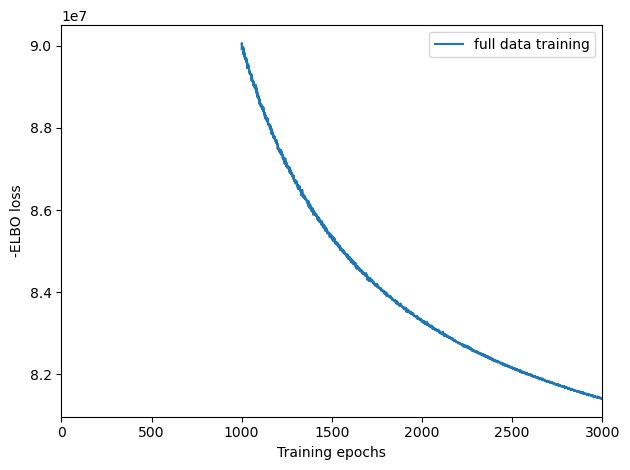

In [20]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [21]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [07:21<00:00,  2.26it/s]


'/home/ssobti/projects/farnaz_spatial/output_data/cell2location/predicted_celltype_annot/cell2location_map/N2_alpha200/sp.h5ad'

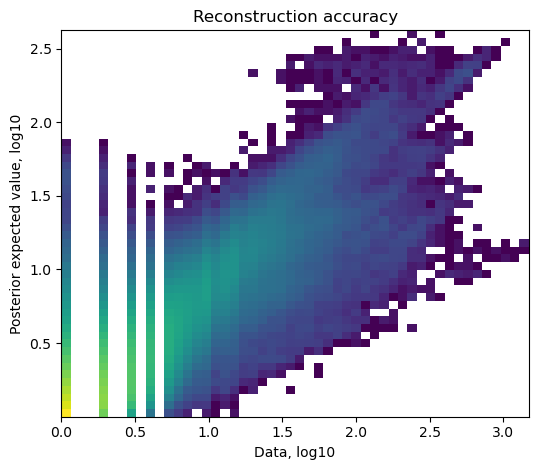

In [22]:
mod.plot_QC()

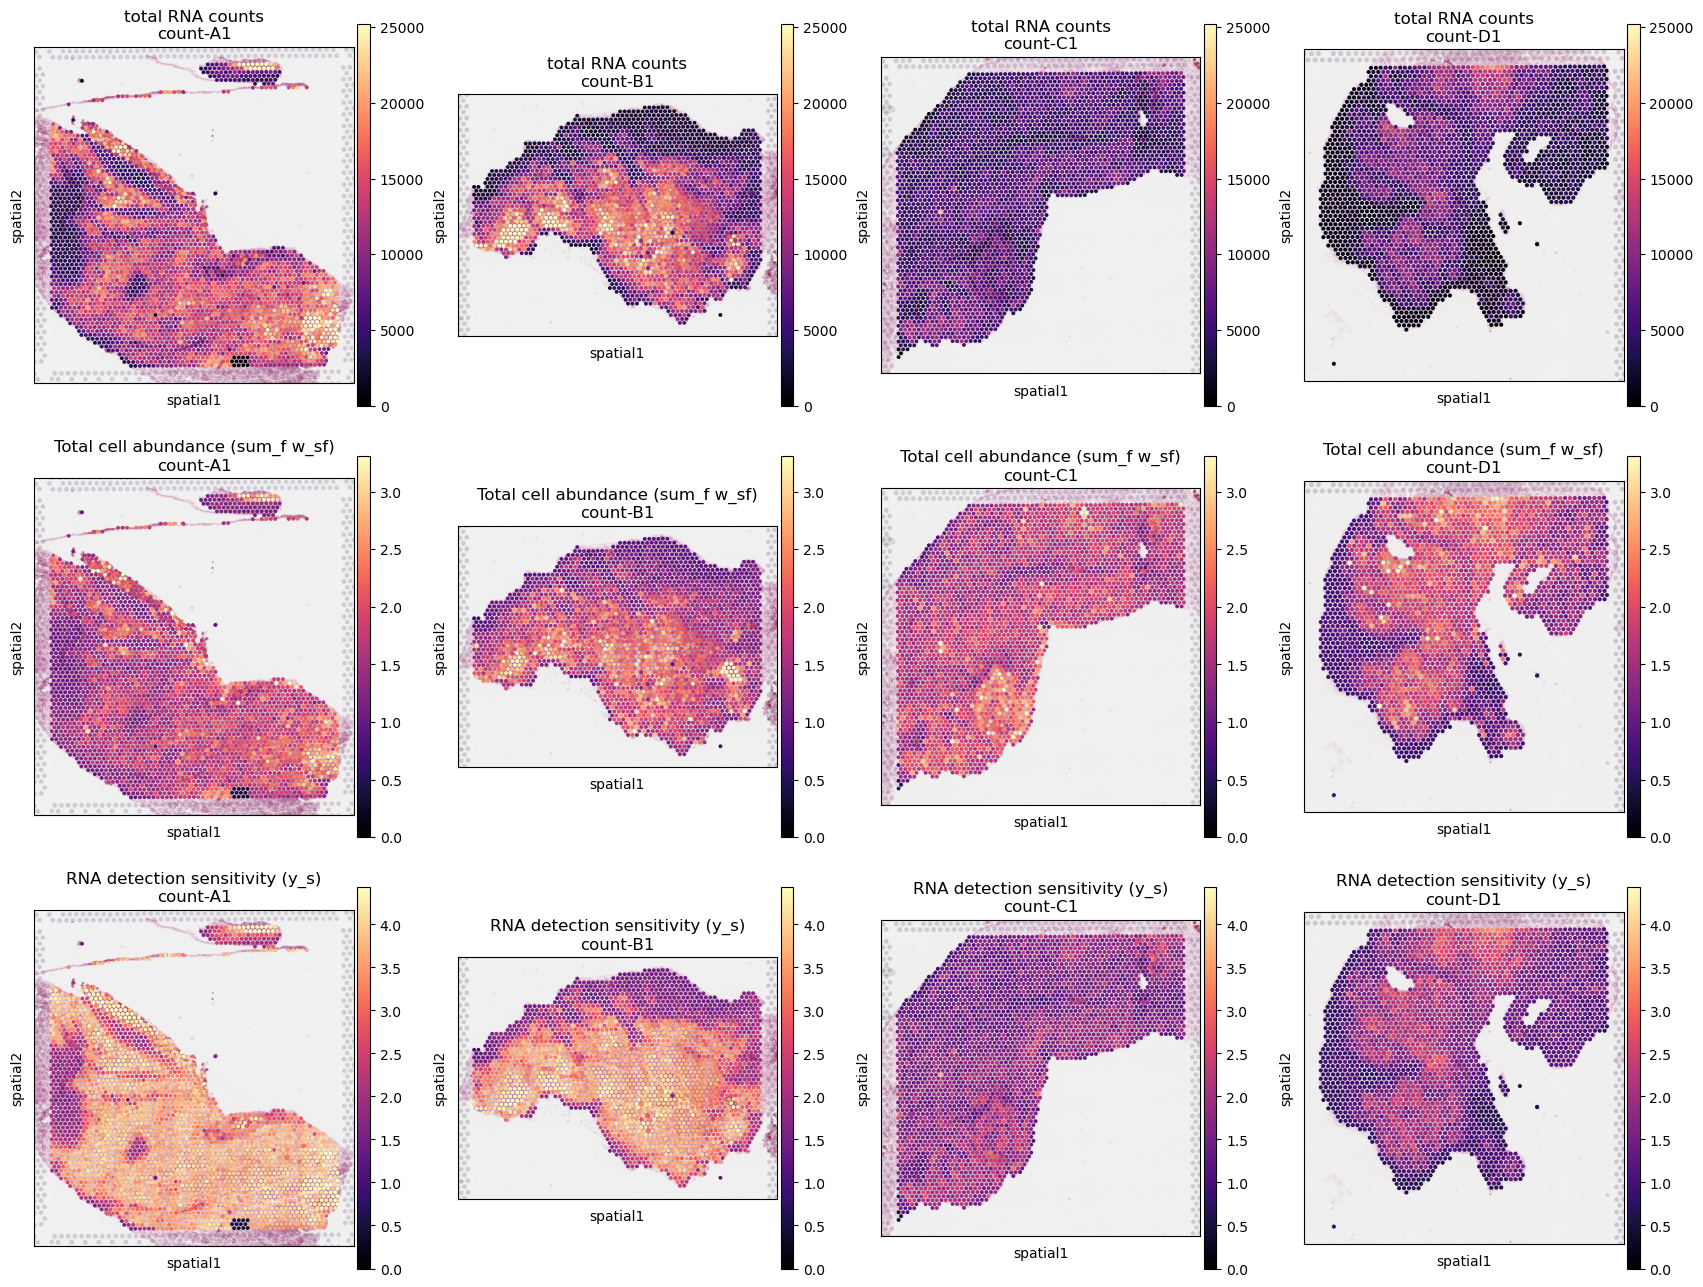

In [23]:
fig = mod.plot_spatial_QC_across_batches()

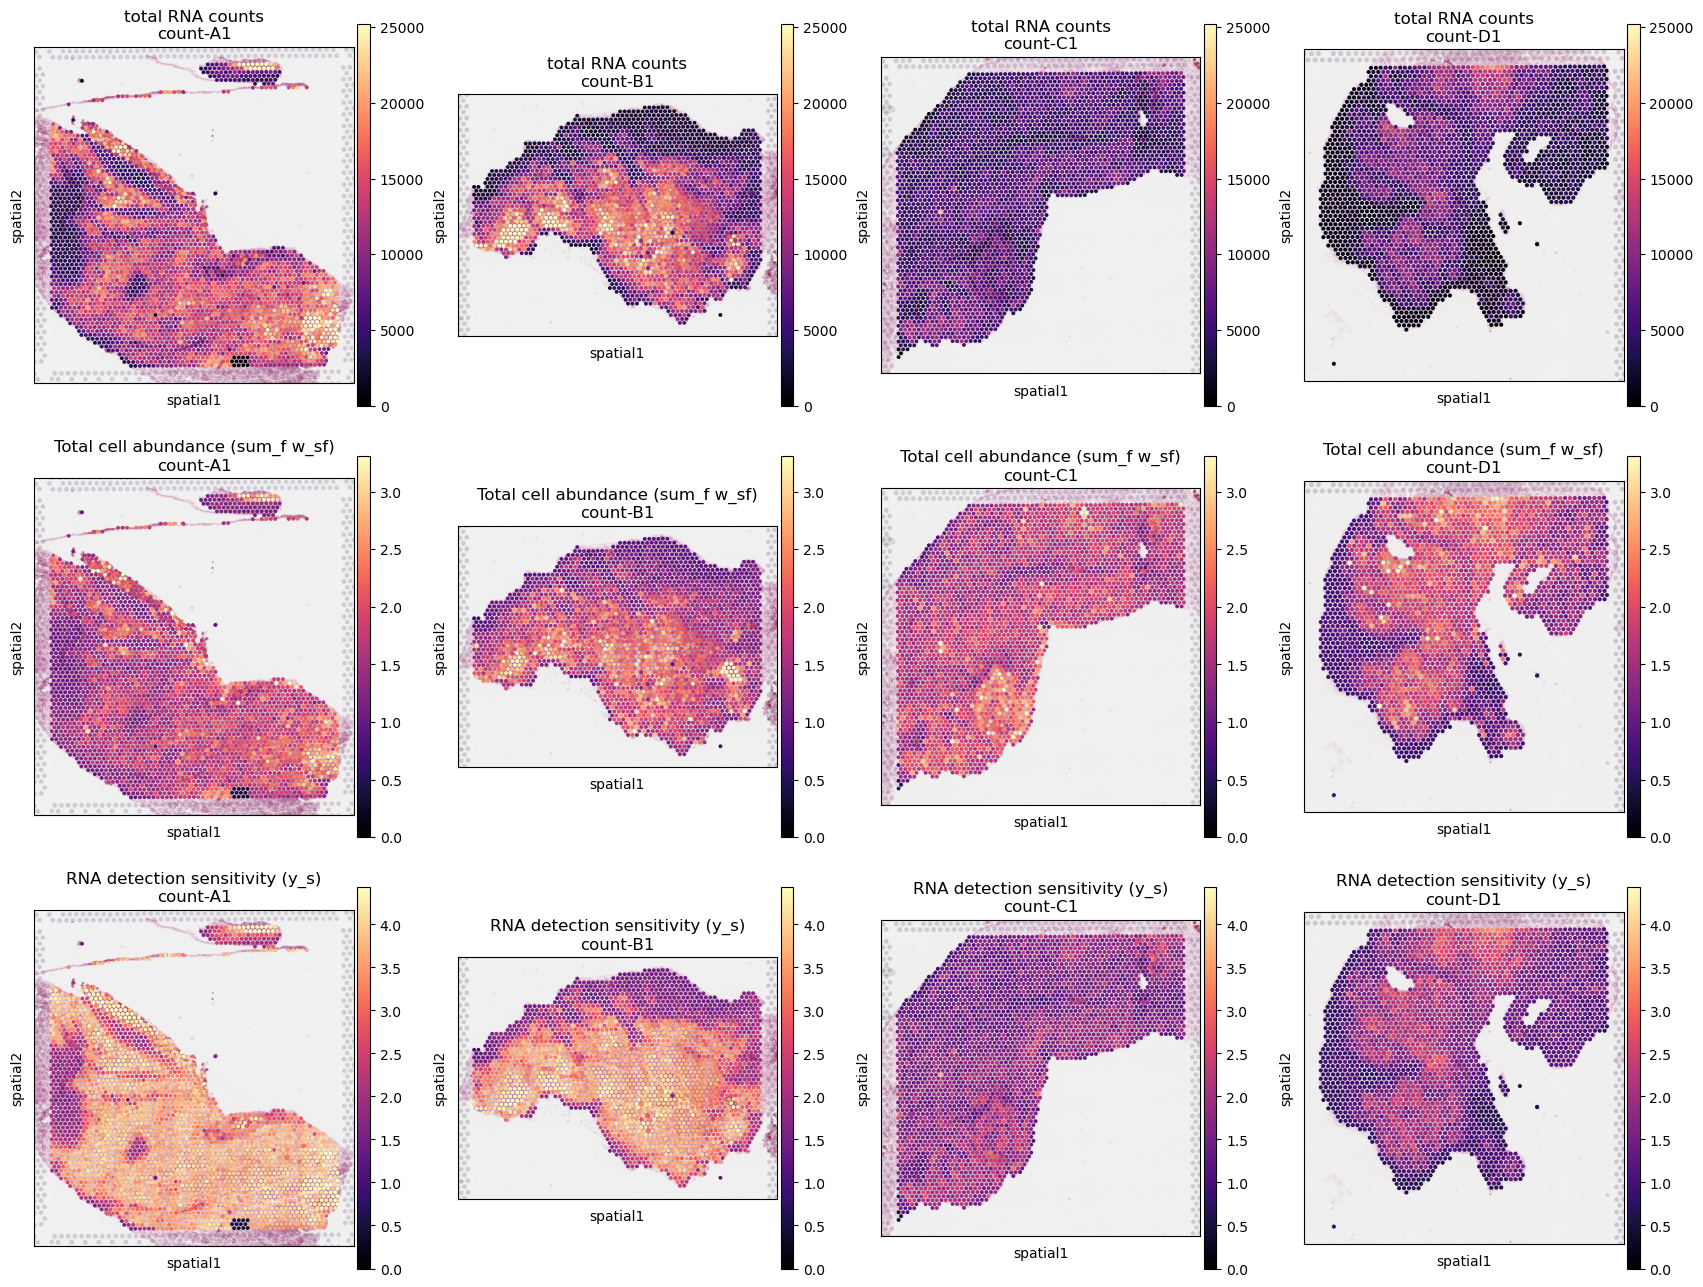

In [24]:
fig